In [4]:
import trackhhl.toy.simple_generator as toy
import numpy as np

### Detector Geometry

In [5]:
N_MODULES = 3
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX]*N_MODULES,
    ly=[LY]*N_MODULES,
    z=[i+Z_SPACING for i in range(N_MODULES)]
)

detector

SimpleDetectorGeometry(module_id=[0, 1, 2], lx=[inf, inf, inf], ly=[inf, inf, inf], z=[1.0, 2.0, 3.0])

### Particle Generator


In [6]:
generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi/6
)
generator

SimpleGenerator(detector_geometry=SimpleDetectorGeometry(module_id=[0, 1, 2], lx=[inf, inf, inf], ly=[inf, inf, inf], z=[1.0, 2.0, 3.0]), primary_vertices=[], phi_min=0.0, phi_max=6.283185307179586, theta_min=0.0, theta_max=0.5235987755982988, rng=Generator(PCG64) at 0x2D3F7B774C0)

In [7]:
N_PARTICLES = 3
event = generator.generate_event(N_PARTICLES)
event.hits

[Hit(hit_id=0, x=-0.11021723419760658, y=-0.40130603261785563, z=1.0, module_id=0, track_id=0),
 Hit(hit_id=3, x=0.1782097161193456, y=-0.09004312202306497, z=1.0, module_id=0, track_id=1),
 Hit(hit_id=6, x=-0.0827902186528216, y=-0.036430973262016185, z=1.0, module_id=0, track_id=2),
 Hit(hit_id=1, x=-0.22043446839521316, y=-0.8026120652357113, z=2.0, module_id=1, track_id=0),
 Hit(hit_id=4, x=0.3564194322386912, y=-0.18008624404612994, z=2.0, module_id=1, track_id=1),
 Hit(hit_id=7, x=-0.1655804373056432, y=-0.07286194652403237, z=2.0, module_id=1, track_id=2),
 Hit(hit_id=2, x=-0.33065170259281973, y=-1.203918097853567, z=3.0, module_id=2, track_id=0),
 Hit(hit_id=5, x=0.5346291483580368, y=-0.2701293660691949, z=3.0, module_id=2, track_id=1),
 Hit(hit_id=8, x=-0.2483706559584648, y=-0.10929291978604855, z=3.0, module_id=2, track_id=2)]

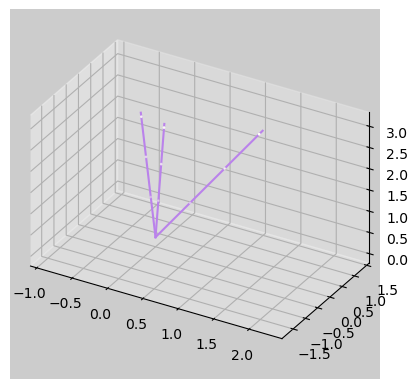

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
event.display(ax)
plt.show()

In [8]:
import numpy as np

#defiine
positions = np.array([[hit.x, hit.y, hit.z] for hit in event.hits])
N_hits = len(event.hits)  # Tot n of hits
epsilon = 0.01  # Small
#whatsup with S? how do i get it ? given or do i need to calculate?

# Angular term
def angular_term(S, epsilon, positions):
    H_angular = 0
    N = len(S)
    
    for a in range(N):
        for b in range(N):
            for c in range(N):
                vec_ab = positions[b] - positions[a]  # Vector from hit a to b
                vec_bc = positions[c] - positions[b]  
                
                # Lengths
                norm_ab = np.linalg.norm(vec_ab)
                norm_bc = np.linalg.norm(vec_bc)
                
            
                if norm_ab > 0 and norm_bc > 0:
                    cos_theta_abc = np.dot(vec_ab, vec_bc) / (norm_ab * norm_bc) #angle
                    
                    # Check if angle is small
                    if cos_theta_abc >= 1 - epsilon:
                        # Contribution to hang
                        H_angular -= 0.5 * S[a, b] * S[b, c]
    
    return H_angular

# Bifurcation term
def bifurcation_term(S):
    H_bifurcation = 0
    N = len(S)
    
    # First sum-fixed a
    for a in range(N):
        for b in range(N):
            for c in range(N):
                H_bifurcation += S[a, b] * S[a, c]
    
    # Second sum-fixed b
    for b in range(N):
        for a in range(N):
            for c in range(N):
                H_bifurcation += S[a, b] * S[c, b]
    
    H_bifurcation *= 0.5  # 1/2 division
    
    return H_bifurcation

# Occupancy term
def occupancy_term(S, N_hits):
    total_sum = np.sum(S)
    difference = total_sum - N_hits
    H_occupancy = 0.5 * difference ** 2
    return H_occupancy

# Total Hamiltonian
def total_hamiltonian(S, positions, N_hits, epsilon):
    H_ang = angular_term(S, epsilon, positions)
    H_bif = bifurcation_term(S)
    H_occ = occupancy_term(S, N_hits)

    H_total = H_ang + H_bif + H_occ
    return H_totalimport numpy as np

# Extract positions from event data
positions = np.array([[hit.x, hit.y, hit.z] for hit in event.hits])
N_hits = len(event.hits)  # Total number of hits
epsilon = 0.01  # Small angle threshold

# Angular term
def angular_term(S, epsilon, positions):
    H_angular = 0
    N = len(S)
    
    # Loop over triplets of hits (a, b, c)
    for a in range(N):
        for b in range(N):
            for c in range(N):
                # Oriented segments S_ab and S_bc
                vec_ab = positions[b] - positions[a]  # Vector from hit a to hit b
                vec_bc = positions[c] - positions[b]  # Vector from hit b to hit c
                
                # Lengths of segments (r_ab and r_bc)
                norm_ab = np.linalg.norm(vec_ab)
                norm_bc = np.linalg.norm(vec_bc)
                
                # Ensure the vectors are not of zero length
                if norm_ab > 0 and norm_bc > 0:
                    # Calculate the cosine of the angle between S_ab and S_bc
                    cos_theta_abc = np.dot(vec_ab, vec_bc) / (norm_ab * norm_bc)
                    
                    # Check if angle is small enough (i.e., cos(theta_abc) >= 1 - epsilon)
                    if cos_theta_abc >= 1 - epsilon:
                        # Contribution to H_angular if the angle is small
                        H_angular -= 0.5 * S[a, b] * S[b, c]
    
    return H_angular

# Bifurcation term
def bifurcation_term(S):
    H_bifurcation = 0
    N = len(S)
    
    # First sum-fixed a
    for a in range(N):
        for b in range(N):
            for c in range(N):
                H_bifurcation += S[a, b] * S[a, c]
    
    # Second sum-fixed b
    for b in range(N):
        for a in range(N):
            for c in range(N):
                H_bifurcation += S[a, b] * S[c, b]
    
    H_bifurcation *= 0.5  # 1/2 division
    
    return H_bifurcation

# Occupancy term
def occupancy_term(S, N_hits):
    total_sum = np.sum(S)
    difference = total_sum - N_hits
    H_occupancy = 0.5 * difference ** 2
    return H_occupancy

# Total Hamiltonian
def total_hamiltonian(S, positions, N_hits, epsilon):
    H_ang = angular_term(S, epsilon, positions)
    H_bif = bifurcation_term(S)
    H_occ = occupancy_term(S, N_hits)

    H_total = H_ang + H_bif + H_occ
    return H_total

# Example usage
# Assume S is provided or calculated somehow; placeholder here:
S = np.random.rand(N_hits, N_hits)  # Example interaction matrix (random for now)

# Calculate total Hamiltonian
H = total_hamiltonian(S, positions, N_hits, epsilon


#whats up with S??
# Calculate total Hamiltonian
H = total_hamiltonian(S, positions, N_hits, epsilon)


NameError: name 'S' is not defined